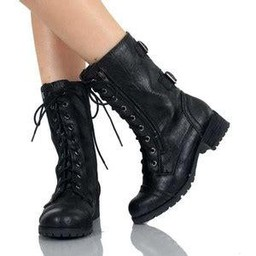

In [ ]:
# Cell 0: Unzipping
import zipfile
import os
from PIL import Image

zip_path = "/content/apparel.zip"
extract_path = "/content/apparel"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


img = Image.open('/content/apparel/black_shoes/40.jpg')
display(img)

In [ ]:
# Imports & Config
import os
import matplotlib.pyplot as plt
from collections import Counter
from PIL import Image
from torchvision import transforms
from collections import defaultdict
import random


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models, optimizers

DATASET_DIR = r"/content/apparel"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_EPOCHS = 10

In [ ]:
# CBAM Attention Module Definition
from tensorflow.keras.layers import Layer, GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, Conv2D, Multiply, Concatenate, Activation
import tensorflow as tf

class CBAM(Layer):
    def __init__(self, filters, reduction_ratio=16):
        super(CBAM, self).__init__()
        self.filters = filters
        self.reduction_ratio = reduction_ratio

        # Channel Attention components
        self.shared_dense_one = Dense(filters // reduction_ratio, activation='relu')
        self.shared_dense_two = Dense(filters)

        # Spatial Attention components
        self.spatial_conv = Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')

    def call(self, x, return_attention=False):
        # Channel Attention
        avg_pool = GlobalAveragePooling2D()(x)
        max_pool = GlobalMaxPooling2D()(x)

        avg_fc = self.shared_dense_two(self.shared_dense_one(avg_pool))
        max_fc = self.shared_dense_two(self.shared_dense_one(max_pool))

        channel_attention = Activation('sigmoid')(avg_fc + max_fc)
        channel_attention = tf.reshape(channel_attention, (-1, 1, 1, self.filters))
        x_out = Multiply()([x, channel_attention])

        # Spatial Attention
        avg_pool_spatial = tf.reduce_mean(x_out, axis=-1, keepdims=True)
        max_pool_spatial = tf.reduce_max(x_out, axis=-1, keepdims=True)
        concat = Concatenate(axis=-1)([avg_pool_spatial, max_pool_spatial])
        spatial_attention = self.spatial_conv(concat)
        x_out = Multiply()([x_out, spatial_attention])

        if return_attention:
            return x_out, spatial_attention
        else:
            return x_out



In [ ]:
# Counting Images Per Class
class_counts = {}
for class_name in sorted(os.listdir(DATASET_DIR)):
    class_path = os.path.join(DATASET_DIR, class_name)
    if os.path.isdir(class_path):
        num_images = len([f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))])
        class_counts[class_name] = num_images

for k, v in class_counts.items():
    print(f"{k}: {v}")

black_dress: 450
black_pants: 870
black_shirt: 715
black_shoes: 766
black_shorts: 328
black_suit: 320
blue_dress: 502
blue_pants: 798
blue_shirt: 741
blue_shoes: 523
blue_shorts: 299
brown_hoodie: 188
brown_pants: 311
brown_shoes: 464
green_pants: 227
green_shirt: 230
green_shoes: 455
green_shorts: 135
green_suit: 243
pink_hoodie: 347
pink_pants: 246
pink_skirt: 513
red_dress: 800
red_hoodie: 349
red_pants: 308
red_shirt: 332
red_shoes: 610
silver_shoes: 403
silver_skirt: 361
white_dress: 818
white_pants: 274
white_shoes: 600
white_shorts: 120
white_suit: 354
yellow_dress: 566
yellow_shorts: 195
yellow_skirt: 409


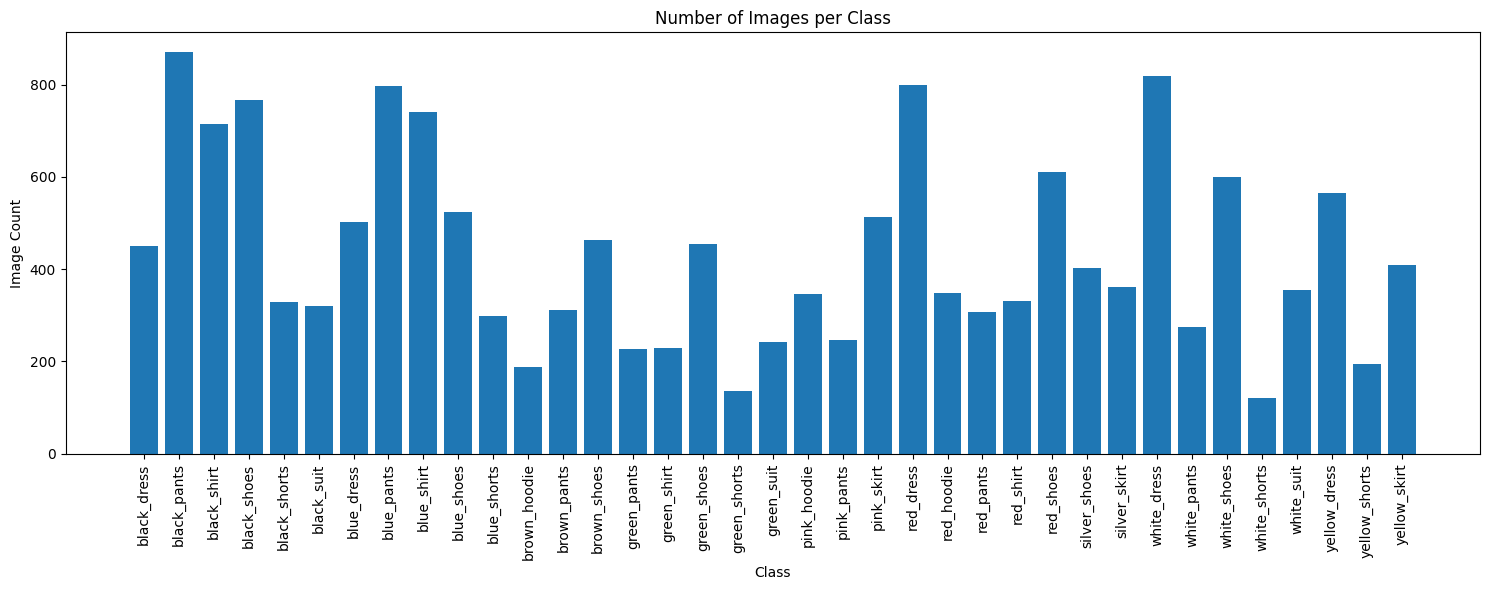

In [ ]:
# Plot Bar Graph for the Dataset
plt.figure(figsize=(15,6))
plt.bar(class_counts.keys(), class_counts.values())
plt.xticks(rotation=90)
plt.title("Number of Images per Class")
plt.xlabel("Class")
plt.ylabel("Image Count")
plt.tight_layout()
plt.show()

In [ ]:
# Defining Paths and Augmentation Strategy
from torchvision.transforms import GaussianBlur

augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
    transforms.RandomApply([GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0))], p=0.3),
])

In [ ]:
# Counting Images per Class and Finding Max Count
class_counts = {}

for class_name in os.listdir(DATASET_DIR):
    class_path = os.path.join(DATASET_DIR, class_name)
    if os.path.isdir(class_path):
        class_counts[class_name] = len(os.listdir(class_path))

max_count = max(class_counts.values())
print("Target count per class (to balance):", max_count)

Target count per class (to balance): 870


In [ ]:
# Performing Augmentation to Balance the Dataset
for class_name, count in class_counts.items():
    class_path = os.path.join(DATASET_DIR, class_name)
    image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    needed = max_count - count
    if needed <= 0:
        continue

    print(f"Augmenting {needed} images for class: {class_name}")

    i = 0
    while i < needed:
        img_name = random.choice(image_files)
        img_path = os.path.join(class_path, img_name)

        try:
            img = Image.open(img_path).convert('RGB')
        except:
            continue

        augmented_img = augmentation(img)
        aug_img_name = f"{os.path.splitext(img_name)[0]}_aug{i}.jpg"
        aug_img_path = os.path.join(class_path, aug_img_name)
        augmented_img.save(aug_img_path)
        i += 1


Augmenting 538 images for class: red_shirt
Augmenting 70 images for class: red_dress
Augmenting 750 images for class: white_shorts
Augmenting 571 images for class: blue_shorts
Augmenting 304 images for class: yellow_dress
Augmenting 415 images for class: green_shoes
Augmenting 72 images for class: blue_pants
Augmenting 627 images for class: green_suit
Augmenting 260 images for class: red_shoes
Augmenting 347 images for class: blue_shoes
Augmenting 542 images for class: black_shorts
Augmenting 682 images for class: brown_hoodie
Augmenting 270 images for class: white_shoes
Augmenting 516 images for class: white_suit
Augmenting 735 images for class: green_shorts
Augmenting 357 images for class: pink_skirt
Augmenting 624 images for class: pink_pants
Augmenting 52 images for class: white_dress
Augmenting 640 images for class: green_shirt
Augmenting 104 images for class: black_shoes
Augmenting 550 images for class: black_suit
Augmenting 461 images for class: yellow_skirt
Augmenting 675 image

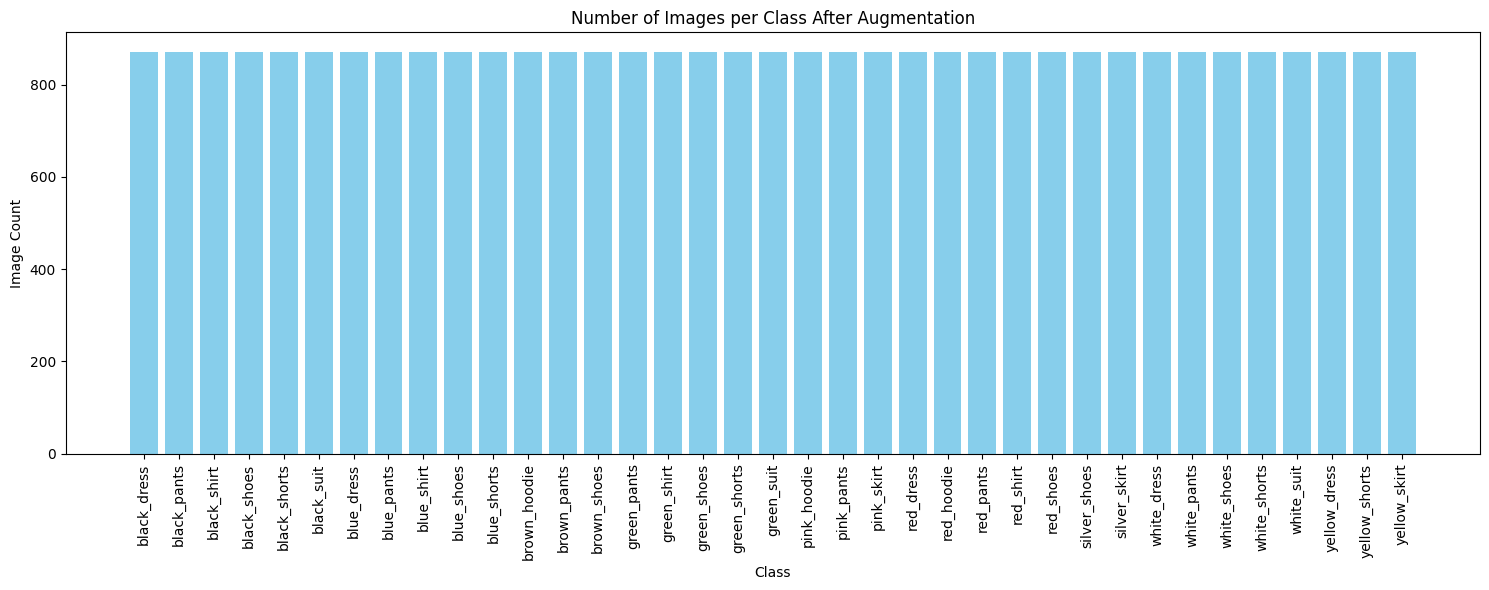

In [ ]:
# Dataset Class Distribution Bar Graph After Augmentation
import matplotlib.pyplot as plt

new_class_counts = {}
for class_name in sorted(os.listdir(DATASET_DIR)):
    class_path = os.path.join(DATASET_DIR, class_name)
    if os.path.isdir(class_path):
        count = len([f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        new_class_counts[class_name] = count

plt.figure(figsize=(15,6))
plt.bar(new_class_counts.keys(), new_class_counts.values(), color='skyblue')
plt.xticks(rotation=90)
plt.title("Number of Images per Class After Augmentation")
plt.xlabel("Class")
plt.ylabel("Image Count")
plt.tight_layout()
plt.show()


In [ ]:
# Data Generators
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    horizontal_flip=True,
    rotation_range=15,
    zoom_range=0.1,
    shear_range=0.1,
    brightness_range=(0.8, 1.2)
)

train_gen = datagen.flow_from_directory(
    DATASET_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    subset='training',
    class_mode='categorical'
)

val_gen = datagen.flow_from_directory(
    DATASET_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    subset='validation',
    class_mode='categorical'
)

Found 25752 images belonging to 37 classes.
Found 6438 images belonging to 37 classes.


In [ ]:
# Compiling Model with CBAM and Embedding Output
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import AdamW  # Use AdamW from keras directly

base_model = ResNet50(include_top=False, weights='imagenet', input_shape=IMG_SIZE + (3,))
for layer in base_model.layers[:-100]:
    layer.trainable = False
for layer in base_model.layers[-100:]:
    layer.trainable = True

x = base_model.output

# CBAM attention module
x = CBAM(filters=x.shape[-1])(x)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
embedding_output = layers.Dense(128, activation='linear', name='embedding')(x)
predictions = layers.Dense(train_gen.num_classes, activation='softmax')(embedding_output)

model = models.Model(inputs=base_model.input, outputs=predictions)

# Compile using AdamW
model.compile(
    optimizer=AdamW(learning_rate=0.0005, weight_decay=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 25,233,800 (96.26 MB)

 Trainable params: 23,798,024 (90.78 MB)

 Non-trainable params: 1,435,776 (5.48 MB)

In [ ]:
# Attention Erasure Callback
import tensorflow.keras.backend as K
import numpy as np

class AttentionErasureCallback(tf.keras.callbacks.Callback):
    def __init__(self, model, cbam_layer_name, erase_ratio=0.2):
        super().__init__()
        self.model = model
        self.cbam_layer_name = cbam_layer_name
        self.erase_ratio = erase_ratio

        cbam_layer = model.get_layer(cbam_layer_name)

        inputs = model.input
        cbam_output, spatial_attention = cbam_layer.call(model.get_layer('resnet50').output, return_attention=True)
        self.attention_model = tf.keras.Model(inputs=inputs, outputs=spatial_attention)

    def on_train_batch_begin(self, batch, logs=None):
        pass



In [ ]:
#Attention Erasure Generator

import tensorflow as tf
import numpy as np
import cv2

class AttentionErasureGenerator(tf.keras.utils.Sequence):
    def __init__(self, base_generator, erase_ratio=0.1, start_epoch=10):
        self.base_generator = base_generator
        self.erase_ratio = erase_ratio  # percentage of area to erase
        self.start_epoch = start_epoch
        self.current_epoch = 0

    def __len__(self):
        return len(self.base_generator)

    def on_epoch_end(self):
        self.base_generator.on_epoch_end()
        self.current_epoch += 1

    def __getitem__(self, idx):
        x_batch, y_batch = self.base_generator[idx]

        if self.current_epoch >= self.start_epoch:
            x_batch = self.apply_erasure(x_batch)

        return x_batch, y_batch

    def apply_erasure(self, images):
        erased_images = []
        for img in images:
            h, w, c = img.shape
            area = h * w
            erase_area = int(area * self.erase_ratio)

            erase_size = int(np.sqrt(erase_area))
            erase_h = np.random.randint(erase_size // 2, erase_size)
            erase_w = np.random.randint(erase_size // 2, erase_size)

            top = np.random.randint(0, h - erase_h)
            left = np.random.randint(0, w - erase_w)

            img_copy = img.copy()
            img_copy[top:top+erase_h, left:left+erase_w, :] = 0.0  # black-out patch
            erased_images.append(img_copy)

        return np.array(erased_images)



In [ ]:
# Wrap train_gen with Attention Erasure Generator

# CBAM layer in model
cbam_layer_name = None
for layer in model.layers:
    if isinstance(layer, CBAM):
        cbam_layer_name = layer.name
        break
print(f"CBAM layer name: {cbam_layer_name}")

cbam_layer = model.get_layer(cbam_layer_name)

# custom layer to wrap CBAM to output spatial attention map
class CBAMWrapper(tf.keras.layers.Layer):
    def __init__(self, cbam_layer):
        super().__init__()
        self.cbam_layer = cbam_layer

    def call(self, x):
        _, spatial_attention = self.cbam_layer.call(x, return_attention=True)
        return spatial_attention

# The wrapper layer
cbam_wrapper = CBAMWrapper(cbam_layer)

# Building new model:
inputs = model.input
x = base_model(inputs)
spatial_attention = cbam_wrapper(x)

attention_model = tf.keras.Model(inputs=inputs, outputs=spatial_attention)
train_gen_ae = AttentionErasureGenerator(train_gen, erase_ratio=0.1, start_epoch=10)


CBAM layer name: cbam


In [ ]:
# Model Training
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

callbacks = [
    ModelCheckpoint("Apparel(Resnet50+Blur).h5", save_best_only=True, monitor="val_loss", mode="min"),
    EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.7,
        patience=2,
        verbose=1,
        min_lr=1e-4
    )
]

history = model.fit(
    train_gen_ae,
    validation_data=val_gen,
    epochs=100,
    steps_per_epoch=100,
    validation_steps=20,
    callbacks=callbacks,
    verbose=1
)



Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - accuracy: 0.0631 - loss: 3.4990

100/100 ━━━━━━━━━━━━━━━━━━━━ 64s 639ms/step - accuracy: 0.0634 - loss: 3.4975 - val_accuracy: 0.0625 - val_loss: 5.3650 - learning_rate: 5.0000e-04
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - accuracy: 0.1372 - loss: 2.8907

100/100 ━━━━━━━━━━━━━━━━━━━━ 58s 581ms/step - accuracy: 0.1373 - loss: 2.8898 - val_accuracy: 0.0828 - val_loss: 4.6079 - learning_rate: 5.0000e-04
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - accuracy: 0.1936 - loss: 2.5922

100/100 ━━━━━━━━━━━━━━━━━━━━ 59s 590ms/step - accuracy: 0.1937 - loss: 2.5918 - val_accuracy: 0.1922 - val_loss: 2.8779 - learning_rate: 5.0000e-04
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 77s 778ms/step - accuracy: 0.2432 - loss: 2.3741 - val_accuracy: 0.1844 - val_loss: 3.0896 - learning_rate: 5.0000e-04
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.2641 - loss: 2.2873
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00035000001662410796.
100/100 ━━━━━━━━━━━━━━━━━━━━ 82s 830ms/step - accuracy: 0.2642 - loss: 2.2869 - val_accuracy: 0.1984 - val_loss: 3.2067 - learning_rate: 5.0000e-04
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 82s 831ms/step - accuracy: 0.2985 - loss: 2.1229 - val_accuracy: 0.1844 - val_loss: 3.5566 - learning_rate: 3.5000e-04
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.3500 - loss: 1.9417
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00024500001163687554.
100/100 ━━━━━━━━━━━━━━━━━━━━ 38s 379ms/step - accura

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 9: ReduceLROnPlateau reducing learning rate to 0.00017150000203400848.
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - accuracy: 0.4944 - loss: 1.4632 - val_accuracy: 0.1266 - val_loss: 4.3289 - learning_rate: 2.4500e-04
Epoch 10/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 82s 662ms/step - accuracy: 0.4277 - loss: 1.7120 - val_accuracy: 0.2219 - val_loss: 3.6197 - learning_rate: 1.7150e-04
Epoch 11/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - accuracy: 0.4740 - loss: 1.5733

100/100 ━━━━━━━━━━━━━━━━━━━━ 83s 840ms/step - accuracy: 0.4742 - loss: 1.5729 - val_accuracy: 0.4953 - val_loss: 1.3996 - learning_rate: 1.7150e-04
Epoch 12/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - accuracy: 0.5033 - loss: 1.4667

100/100 ━━━━━━━━━━━━━━━━━━━━ 59s 589ms/step - accuracy: 0.5033 - loss: 1.4669 - val_accuracy: 0.5813 - val_loss: 1.3260 - learning_rate: 1.7150e-04
Epoch 13/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.5365 - loss: 1.3833

100/100 ━━━━━━━━━━━━━━━━━━━━ 79s 798ms/step - accuracy: 0.5366 - loss: 1.3830 - val_accuracy: 0.5672 - val_loss: 1.2968 - learning_rate: 1.7150e-04
Epoch 14/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - accuracy: 0.5647 - loss: 1.3309

100/100 ━━━━━━━━━━━━━━━━━━━━ 82s 828ms/step - accuracy: 0.5646 - loss: 1.3311 - val_accuracy: 0.6016 - val_loss: 1.2843 - learning_rate: 1.7150e-04
Epoch 15/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 55s 558ms/step - accuracy: 0.5894 - loss: 1.2923 - val_accuracy: 0.5344 - val_loss: 1.4777 - learning_rate: 1.7150e-04
Epoch 16/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.5945 - loss: 1.2438
Epoch 16: ReduceLROnPlateau reducing learning rate to 0.00012004999734926967.
100/100 ━━━━━━━━━━━━━━━━━━━━ 79s 799ms/step - accuracy: 0.5946 - loss: 1.2436 - val_accuracy: 0.3969 - val_loss: 2.1090 - learning_rate: 1.7150e-04
Epoch 17/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.6439 - loss: 1.0882

100/100 ━━━━━━━━━━━━━━━━━━━━ 56s 566ms/step - accuracy: 0.6439 - loss: 1.0883 - val_accuracy: 0.7063 - val_loss: 0.8995 - learning_rate: 1.2005e-04
Epoch 18/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 90ms/step - accuracy: 0.6672 - loss: 1.0568 - val_accuracy: 0.6328 - val_loss: 1.0791 - learning_rate: 1.2005e-04
Epoch 19/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - accuracy: 0.6360 - loss: 1.0788
Epoch 19: ReduceLROnPlateau reducing learning rate to 0.0001.
100/100 ━━━━━━━━━━━━━━━━━━━━ 83s 826ms/step - accuracy: 0.6359 - loss: 1.0792 - val_accuracy: 0.6156 - val_loss: 1.2456 - learning_rate: 1.2005e-04
Epoch 20/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 58s 582ms/step - accuracy: 0.6557 - loss: 1.0279 - val_accuracy: 0.6500 - val_loss: 0.9796 - learning_rate: 1.0000e-04
Epoch 21/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 81s 814ms/step - accuracy: 0.6892 - loss: 0.9265 - val_accuracy: 0.4922 - val_loss: 1.9064 - learning_rate: 1.0000e-04
Epoch 22/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 57s 571ms/step - accuracy: 0.

100/100 ━━━━━━━━━━━━━━━━━━━━ 81s 817ms/step - accuracy: 0.7316 - loss: 0.8119 - val_accuracy: 0.7844 - val_loss: 0.6483 - learning_rate: 1.0000e-04
Epoch 26/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 80s 809ms/step - accuracy: 0.7314 - loss: 0.7918 - val_accuracy: 0.7406 - val_loss: 0.7662 - learning_rate: 1.0000e-04
Epoch 27/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step - accuracy: 0.6614 - loss: 0.8697 - val_accuracy: 0.5938 - val_loss: 1.3530 - learning_rate: 1.0000e-04
Epoch 28/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 81s 807ms/step - accuracy: 0.7615 - loss: 0.7259 - val_accuracy: 0.4812 - val_loss: 2.2307 - learning_rate: 1.0000e-04
Epoch 29/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 83s 834ms/step - accuracy: 0.7616 - loss: 0.7480 - val_accuracy: 0.7516 - val_loss: 0.8058 - learning_rate: 1.0000e-04
Epoch 30/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 82s 825ms/step - accuracy: 0.7656 - loss: 0.7138 - val_accuracy: 0.7203 - val_loss: 0.8189 - learning_rate: 1.0000e-04
Epoch 31/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 58s 58

100/100 ━━━━━━━━━━━━━━━━━━━━ 86s 863ms/step - accuracy: 0.8118 - loss: 0.5780 - val_accuracy: 0.8156 - val_loss: 0.5555 - learning_rate: 1.0000e-04
Epoch 36/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 155ms/step - accuracy: 0.8422 - loss: 0.4512 - val_accuracy: 0.7641 - val_loss: 0.7437 - learning_rate: 1.0000e-04
Epoch 37/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 142s 989ms/step - accuracy: 0.8041 - loss: 0.5736 - val_accuracy: 0.7437 - val_loss: 0.8504 - learning_rate: 1.0000e-04
Epoch 38/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 82s 826ms/step - accuracy: 0.8004 - loss: 0.5848 - val_accuracy: 0.7031 - val_loss: 0.9290 - learning_rate: 1.0000e-04
Epoch 39/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 57s 577ms/step - accuracy: 0.8110 - loss: 0.5798 - val_accuracy: 0.7906 - val_loss: 0.5930 - learning_rate: 1.0000e-04
Epoch 40/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step - accuracy: 0.8394 - loss: 0.5042

100/100 ━━━━━━━━━━━━━━━━━━━━ 86s 871ms/step - accuracy: 0.8392 - loss: 0.5046 - val_accuracy: 0.8125 - val_loss: 0.5471 - learning_rate: 1.0000e-04
Epoch 41/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 77s 770ms/step - accuracy: 0.8156 - loss: 0.5288 - val_accuracy: 0.7281 - val_loss: 0.8668 - learning_rate: 1.0000e-04
Epoch 42/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 58s 581ms/step - accuracy: 0.8320 - loss: 0.5143 - val_accuracy: 0.7375 - val_loss: 0.8548 - learning_rate: 1.0000e-04
Epoch 43/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 57s 571ms/step - accuracy: 0.8118 - loss: 0.5469 - val_accuracy: 0.2750 - val_loss: 4.3119 - learning_rate: 1.0000e-04
Epoch 44/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 58s 585ms/step - accuracy: 0.8401 - loss: 0.5018 - val_accuracy: 0.7937 - val_loss: 0.6147 - learning_rate: 1.0000e-04
Epoch 45/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 191ms/step - accuracy: 0.8884 - loss: 0.4301 - val_accuracy: 0.8188 - val_loss: 0.5678 - learning_rate: 1.0000e-04
Epoch 46/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 48

100/100 ━━━━━━━━━━━━━━━━━━━━ 63s 632ms/step - accuracy: 0.8358 - loss: 0.4911 - val_accuracy: 0.8594 - val_loss: 0.5092 - learning_rate: 1.0000e-04
Epoch 47/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 76s 767ms/step - accuracy: 0.8258 - loss: 0.5288 - val_accuracy: 0.6734 - val_loss: 1.2630 - learning_rate: 1.0000e-04
Epoch 48/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.8224 - loss: 0.5340

100/100 ━━━━━━━━━━━━━━━━━━━━ 84s 849ms/step - accuracy: 0.8226 - loss: 0.5336 - val_accuracy: 0.8578 - val_loss: 0.4473 - learning_rate: 1.0000e-04
Epoch 49/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 80s 803ms/step - accuracy: 0.8362 - loss: 0.5099 - val_accuracy: 0.7922 - val_loss: 0.6948 - learning_rate: 1.0000e-04
Epoch 50/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 82s 827ms/step - accuracy: 0.8406 - loss: 0.4781 - val_accuracy: 0.8344 - val_loss: 0.5171 - learning_rate: 1.0000e-04
Epoch 51/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 57s 576ms/step - accuracy: 0.8525 - loss: 0.4700 - val_accuracy: 0.7000 - val_loss: 0.9548 - learning_rate: 1.0000e-04
Epoch 52/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 81s 819ms/step - accuracy: 0.8584 - loss: 0.4264 - val_accuracy: 0.8031 - val_loss: 0.5872 - learning_rate: 1.0000e-04
Epoch 53/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 82s 825ms/step - accuracy: 0.8806 - loss: 0.3710 - val_accuracy: 0.6172 - val_loss: 1.4778 - learning_rate: 1.0000e-04
Epoch 54/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 9

100/100 ━━━━━━━━━━━━━━━━━━━━ 65s 656ms/step - accuracy: 0.8721 - loss: 0.3781 - val_accuracy: 0.8906 - val_loss: 0.3586 - learning_rate: 1.0000e-04
Epoch 63/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 100ms/step - accuracy: 0.8760 - loss: 0.4061 - val_accuracy: 0.8719 - val_loss: 0.3750 - learning_rate: 1.0000e-04
Epoch 64/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 60s 597ms/step - accuracy: 0.8859 - loss: 0.3499 - val_accuracy: 0.7937 - val_loss: 0.6746 - learning_rate: 1.0000e-04
Epoch 65/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 82s 822ms/step - accuracy: 0.8829 - loss: 0.3572 - val_accuracy: 0.7656 - val_loss: 0.7816 - learning_rate: 1.0000e-04
Epoch 66/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 57s 576ms/step - accuracy: 0.8604 - loss: 0.4069 - val_accuracy: 0.8578 - val_loss: 0.4716 - learning_rate: 1.0000e-04
Epoch 67/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 58s 589ms/step - accuracy: 0.8782 - loss: 0.3846 - val_accuracy: 0.8172 - val_loss: 0.5800 - learning_rate: 1.0000e-04
Epoch 68/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 59s 5

In [ ]:
# Feature Extractor Model
feature_extractor = models.Model(inputs=model.input, outputs=model.get_layer('embedding').output)

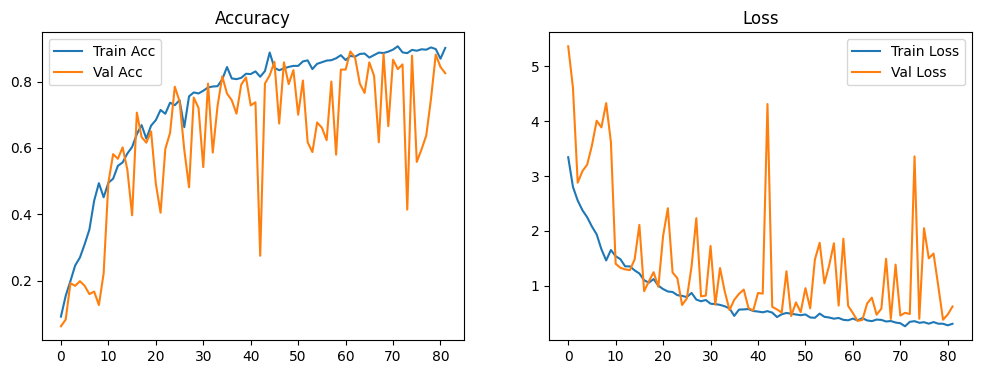

In [ ]:
# Training History
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

In [ ]:
# Embedding Extraction from All Dataset Images
import numpy as np
import os
import tensorflow as tf

image_paths = []
image_embeddings = []

batch_size = 32
batch_images = []
batch_image_paths = []

for class_folder in os.listdir(DATASET_DIR):
    folder_path = os.path.join(DATASET_DIR, class_folder)
    if not os.path.isdir(folder_path):
        continue
    for img_file in os.listdir(folder_path):
        if not img_file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
            continue
        img_path = os.path.join(folder_path, img_file)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
        img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0

        batch_images.append(img_array)
        batch_image_paths.append(img_path)

        if len(batch_images) == batch_size:
            batch_images_np = np.array(batch_images)
            batch_embeddings = feature_extractor.predict(batch_images_np, verbose=0)

            image_embeddings.extend(batch_embeddings)
            image_paths.extend(batch_image_paths)

            batch_images = []
            batch_image_paths = []

# Process remaining images in last batch
if batch_images:
    batch_images_np = np.array(batch_images)
    batch_embeddings = feature_extractor.predict(batch_images_np, verbose=0)
    image_embeddings.extend(batch_embeddings)
    image_paths.extend(batch_image_paths)

image_embeddings = np.array(image_embeddings)



In [ ]:
# Similarity Function for Top-5 Matches
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import tensorflow as tf

def get_top_k_similar_images(query_path, k=5):
    img = tf.keras.preprocessing.image.load_img(query_path, target_size=IMG_SIZE)
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    query_embedding = feature_extractor.predict(img_array, verbose=0)
    sims = cosine_similarity(query_embedding, image_embeddings)[0]

    top_indices = sims.argsort()[-k:][::-1]
    top_paths = [image_paths[i] for i in top_indices]
    top_scores = [sims[i] for i in top_indices]

    return list(zip(top_paths, top_scores))

In [ ]:
# Visualization of Top Matches
import matplotlib.pyplot as plt

def visualize_top_matches(query_path, matches):
    plt.figure(figsize=(15,5))
    query_img = tf.keras.preprocessing.image.load_img(query_path, target_size=IMG_SIZE)
    plt.subplot(1, len(matches)+1, 1)
    plt.imshow(query_img)
    plt.title("Query")
    plt.axis('off')

    for i, (path, score) in enumerate(matches):
        img = tf.keras.preprocessing.image.load_img(path, target_size=IMG_SIZE)
        plt.subplot(1, len(matches)+1, i+2)
        plt.imshow(img)
        plt.title(f"Score: {score:.2f}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


Top 5 similar images (excluding duplicates/augmented):
/content/apparel/brown_hoodie/000039_aug101.jpg (similarity: 0.982)
/content/apparel/brown_hoodie/000229.jpg (similarity: 0.952)
/content/apparel/brown_hoodie/000110_aug616.jpg (similarity: 0.951)
/content/apparel/brown_hoodie/000272_aug157.jpg (similarity: 0.942)
/content/apparel/brown_hoodie/000195_aug403.jpg (similarity: 0.940)


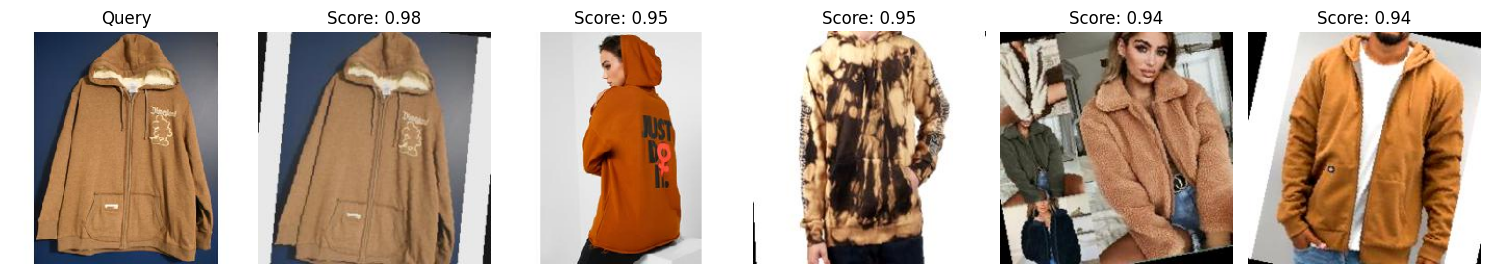

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np
import os


def get_base_name(img_path):
    return os.path.basename(img_path).split('_aug')[0]


def filter_unique_base_images(matches, query_path, k=5):
    query_base = get_base_name(query_path)
    seen_bases = set()
    filtered_matches = []

    for path, score in matches:
        base = get_base_name(path)
        if base == query_base:
            continue
        if base not in seen_bases:
            seen_bases.add(base)
            filtered_matches.append((path, score))
        if len(filtered_matches) == k:
            break

    return filtered_matches


def visualize_top_matches(query_img, top_matches):
    plt.figure(figsize=(15, 5))


    plt.subplot(1, len(top_matches)+1, 1)
    img = image.load_img(query_img, target_size=(224, 224))
    plt.imshow(img)
    plt.title("Query")
    plt.axis('off')


    for i, (path, score) in enumerate(top_matches):
        plt.subplot(1, len(top_matches)+1, i+2)
        img = image.load_img(path, target_size=(224, 224))
        plt.imshow(img)
        plt.title(f"Score: {score:.2f}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example Query
query_image_path = r"/content/apparel/brown_hoodie/000039.jpg"

top_matches_all = get_top_k_similar_images(query_image_path, k=20)
top_matches = filter_unique_base_images(top_matches_all, query_image_path, k=5)

print("Top 5 similar images (excluding duplicates/augmented):")
for path, score in top_matches:
    print(f"{path} (similarity: {score:.3f})")

visualize_top_matches(query_image_path, top_matches)